## Shortlist Promising Models - Gradient Boosting Classifier

#### 0. Import modules and define parameters

In [1]:
import sys
sys.path.append("..")

import general_utils
import data_prepare_utils
import bin_class_utils
from sklearn.pipeline import Pipeline
import time
import pandas as pd

In [2]:
start = time.time()

In [3]:
TRAIN_FILE_PATH = "./data/train_df.csv"
VALIDATION_FILE_PATH = "./data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "GradientBoostingClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['uid', 'app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']
PERM_DROP_THRESHOLD_PERCENT = 0.15

#### 1. Import Data

In [4]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


#### 2. Sample smaller training sets for fast exploration

In [5]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


#### 3. Check attribute types

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_df_sample.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list
attr_list

['uid',
 'task_id',
 'adv_id',
 'creat_type_cd',
 'adv_prim_id',
 'dev_id',
 'inter_type_cd',
 'slot_id',
 'spread_app_id',
 'tags',
 'app_first_class',
 'app_second_class',
 'age',
 'city',
 'city_rank',
 'device_name',
 'device_size',
 'career',
 'gender',
 'net_type',
 'residence',
 'his_app_size',
 'his_on_shelf_time',
 'app_score',
 'emui_dev',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_onlinerate',
 'communication_avgonline_30d',
 'indu_name',
 'pt_d']

#### 4. Predefined data processing strategy in prep.ipynb

In [7]:
train_df_sample = data_prepare_utils.drop_duplicate_obs(train_df_sample)


Drop duplicate observations:
df.shape:  (33525, 36)
drop_dup_df.shape:  (33519, 36)


In [8]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                        'app_score',
                                                                                        'his_on_shelf_time',
                                                                                        'task_id',
                                                                                        'spread_app_id',
                                                                                        'tags',
                                                                                        'dev_id'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 []),
                                ('categorical',
                                 Pipeline(steps=[('column_dropper',
                                                  DropColumnsTransformer(attrs_to_drop=['...
                                  'adv_prim_id', 'dev_id', 'inter_type_cd',
                                  'slot_id', 'spread_app_id', 'tags',
                                  'app_first_class', 'app_second_class', 'age',
                                  'city', 'city_rank', 'device_name',
                                  'device_size', 'career', 'gender', 'net_type',
                                  'residence', 'his_app_size',
                                  'his_on_shelf_time', 'app_score', 'emui_dev',
                                  'list_time', 'device_price',
                                  'up_life_duration', 'up_membership_grade',
                                  'membership_life_duration', ...])])

#### 5. Define default model

In [9]:
estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)
estimator

GradientBoostingClassifier(random_state=42)

#### 6. Define composite model

In [10]:
composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])
composite_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', GradientBoostingClassifier(random_state=42))])

In [11]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]
del train_df_sample

In [12]:
composite_estimator.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['uid',
                                                                                                         'app_score',
                                                                                                         'his_on_shelf_time',
                                                                                                         'task_id',
                                                                                                         'spread_app_id',
                                                                                                         'tags',
                                                                                                         'dev_id'])),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('categorical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropCol...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', GradientBoostingClassifier(random_state=42))])

#### 7. Evaluate model performance on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.9654822637906859

Check classification report
{'0': {'precision': 0.9655944139412748, 'recall': 0.9998764020640856, 'f1-score': 0.9824364326375712, 'support': 32363.0}, '1': {'precision': 0.42857142857142855, 'recall': 0.0025951557093425604, 'f1-score': 0.005159071367153912, 'support': 1156.0}, 'accuracy': 0.9654822637906859, 'macro avg': {'precision': 0.6970829212563516, 'recall': 0.5012357788867141, 'f1-score': 0.49379775200236253, 'support': 33519.0}, 'weighted avg': {'precision': 0.9470736176440242, 'recall': 0.9654822637906859, 'f1-score': 0.948732186400255, 'support': 33519.0}}

Check confusion matrix
train sample set confusion matrix: 
[[32359     4]
 [ 1153     3]]
True Positives =  32359
True Negatives =  3
False Positives(Type I error) =  4
False Negatives(Type II error) =  1153

Check cross validation score

accuracy scores: [0.96524463 0.96554296 0.96554296

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

recall scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

f1 scores: [0. 0. 0. 0. 0.]
np.mean(scores): 0.0000
np.std(scores, ddof=1): 0.0000

Check the ROC Curve and AUC


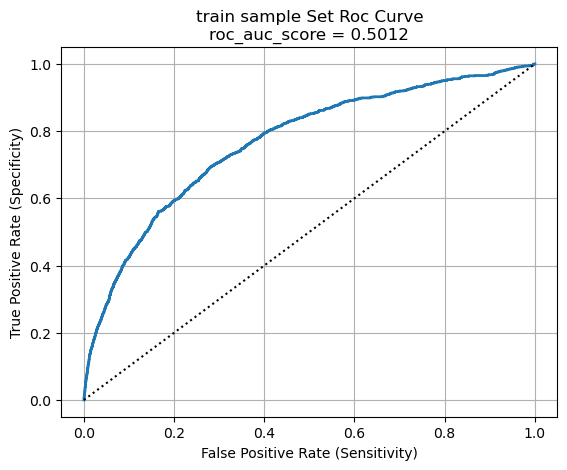


Check Precision-Recall Curve and Average Precision Score


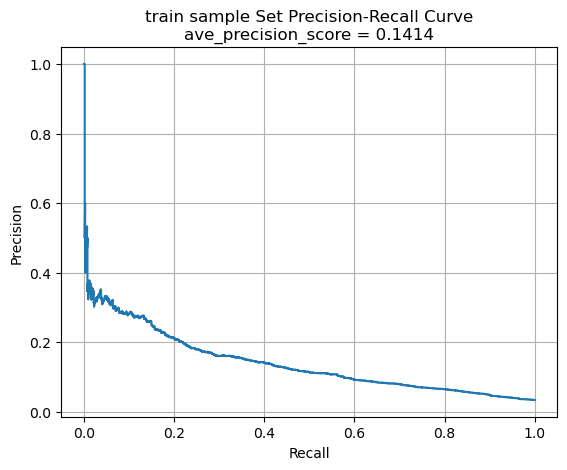

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.9655,0.428571,0.002595,0.9654,0.0,0.0,0.0,0.5012


In [13]:
eval_train_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator, "train sample", CVS_SCORING_LIST)
eval_train_results

#### 8. Read in and sample validation data set

In [14]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [15]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [16]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

#### 9. Evaluate model performance on validation set

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.9649206538599212

Check classification report
{'0': {'precision': 0.9654966571155683, 'recall': 0.9993821057834898, 'f1-score': 0.982147194559145, 'support': 8092.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 289.0}, 'accuracy': 0.9649206538599212, 'macro avg': {'precision': 0.48274832855778416, 'recall': 0.4996910528917449, 'f1-score': 0.4910735972795725, 'support': 8381.0}, 'weighted avg': {'precision': 0.9322036689391694, 'recall': 0.9649206538599212, 'f1-score': 0.9482800499191745, 'support': 8381.0}}

Check confusion matrix
validation sample set confusion matrix: 
[[8087    5]
 [ 289    0]]
True Positives =  8087
True Negatives =  0
False Positives(Type I error) =  5
False Negatives(Type II error) =  289

Check cross validation score

accuracy scores: [0.96422182 0.96479714 0.96539379 0.96539379 0.96539379]
np.mean(scores): 0.965

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0.  0.  0.5 0.  0. ]
np.mean(scores): 0.1000
np.std(scores, ddof=1): 0.2236

recall scores: [0.         0.         0.01724138 0.         0.        ]
np.mean(scores): 0.0034
np.std(scores, ddof=1): 0.0077

f1 scores: [0.         0.         0.03333333 0.         0.        ]
np.mean(scores): 0.0067
np.std(scores, ddof=1): 0.0149

Check the ROC Curve and AUC


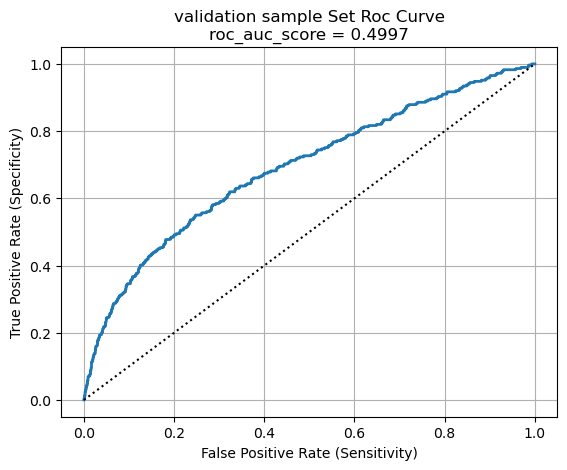


Check Precision-Recall Curve and Average Precision Score


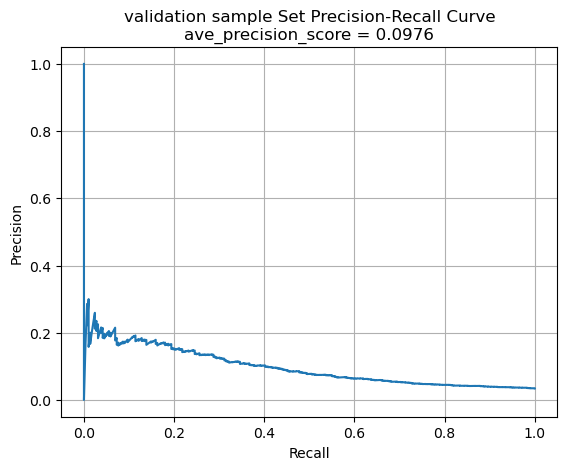

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample,0.9649,0.0,0.0,0.965,0.1,0.0034,0.0067,0.4997


In [17]:
eval_validation_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator, "validation sample", CVS_SCORING_LIST)
eval_validation_results

#### 10. Check the most significant attributes

In [18]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    composite_estimator, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,adv_id,0.053603,0.002183
1,average_precision,slot_id,0.043309,0.003156
2,average_precision,city,0.012961,0.001394
3,average_precision,age,0.012066,0.001944
4,average_precision,device_size,0.007031,0.001541
5,average_precision,his_app_size,0.006827,0.001260
6,average_precision,communication_onlinerate,0.006441,0.001109
7,average_precision,career,0.006397,0.001760
8,average_precision,adv_prim_id,0.005482,0.001684
9,average_precision,device_price,0.002916,0.000559


#### 11. Feature selection and engineering

In [19]:
common_least_important_attrs = bin_class_utils.drop_least_important_attrs(perm_results_df, PERM_DROP_THRESHOLD_PERCENT)
common_least_important_attrs

['device_size',
 'pt_d',
 'career',
 'emui_dev',
 'communication_avgonline_30d',
 'adv_prim_id',
 'gender',
 'list_time',
 'city_rank',
 'communication_onlinerate',
 'device_price']

#### 12. Fit and evaluate again

In [20]:
attrs_to_drop_exp = list(set(ATTRS_TO_DROP + common_least_important_attrs))
attrs_to_drop_exp

['device_size',
 'pt_d',
 'spread_app_id',
 'career',
 'emui_dev',
 'app_score',
 'communication_avgonline_30d',
 'adv_prim_id',
 'gender',
 'list_time',
 'uid',
 'task_id',
 'tags',
 'dev_id',
 'city_rank',
 'his_on_shelf_time',
 'communication_onlinerate',
 'device_price']

In [21]:
preprocessor_exp = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop_exp, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)

estimator_exp = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

composite_estimator_exp = Pipeline(steps=[
    ('preprocessor', preprocessor_exp), 
    ('estimator', estimator_exp)
])

In [22]:
composite_estimator_exp.fit(
    train_cap_x_df,
    train_y_df.values.ravel()
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('column_dropper',
                                                                   DropColumnsTransformer(attrs_to_drop=['device_size',
                                                                                                         'pt_d',
                                                                                                         'spread_app_id',
                                                                                                         'career',
                                                                                                         'emui_dev',
                                                                                                         'app_score',
                                                                                                         'communication_avgonline_30d',
                                                                                                         'adv_prim_id',
                                                                                                         'gender',
                                                                                                         'list_time',
                                                                                                         'uid',
                                                                                                         'task_id',
                                                                                                         'tags',
                                                                                                         'dev_id',
                                                                                                         'city_rank',
                                                                                                         'his_on_shelf_time',
                                                                                                         'co...
                                                   'app_first_class',
                                                   'app_second_class', 'age',
                                                   'city', 'city_rank',
                                                   'device_name', 'device_size',
                                                   'career', 'gender',
                                                   'net_type', 'residence',
                                                   'his_app_size',
                                                   'his_on_shelf_time',
                                                   'app_score', 'emui_dev',
                                                   'list_time', 'device_price',
                                                   'up_life_duration',
                                                   'up_membership_grade',
                                                   'membership_life_duration', ...])])),
                ('estimator', GradientBoostingClassifier(random_state=42))])

Evaluate the trained estimator performance on train sample exp set
Check accuracy score
train sample exp set accuracy score: 0.9655419314418688

Check classification report
{'0': {'precision': 0.9655964671480576, 'recall': 0.9999382010320428, 'f1-score': 0.9824673254701944, 'support': 32363.0}, '1': {'precision': 0.6, 'recall': 0.0025951557093425604, 'f1-score': 0.005167958656330749, 'support': 1156.0}, 'accuracy': 0.9655419314418688, 'macro avg': {'precision': 0.7827982335740288, 'recall': 0.5012666783706927, 'f1-score': 0.4938176420632626, 'support': 33519.0}, 'weighted avg': {'precision': 0.9529878118772215, 'recall': 0.9655419314418688, 'f1-score': 0.948762320307844, 'support': 33519.0}}

Check confusion matrix
train sample exp set confusion matrix: 
[[32361     2]
 [ 1153     3]]
True Positives =  32361
True Negatives =  3
False Positives(Type I error) =  2
False Negatives(Type II error) =  1153

Check cross validation score

accuracy scores: [0.96539379 0.96449881 0.96524463 0.96

/Users/leon/miniconda3/envs/ctr_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



precision scores: [0.   0.   0.25 0.   0.  ]
np.mean(scores): 0.0500
np.std(scores, ddof=1): 0.1118

recall scores: [0.       0.       0.004329 0.       0.      ]
np.mean(scores): 0.0009
np.std(scores, ddof=1): 0.0019

f1 scores: [0.         0.         0.00851064 0.         0.        ]
np.mean(scores): 0.0017
np.std(scores, ddof=1): 0.0038

Check the ROC Curve and AUC


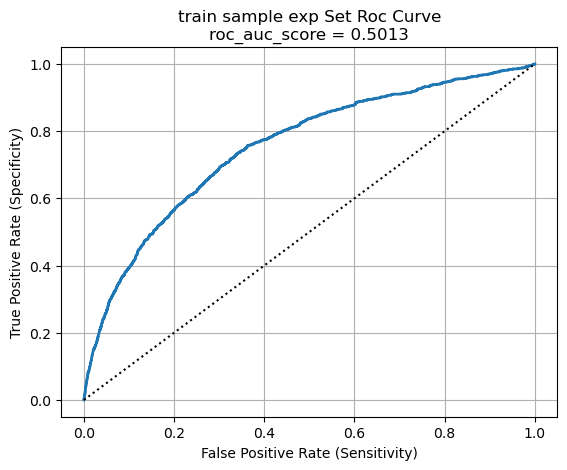


Check Precision-Recall Curve and Average Precision Score


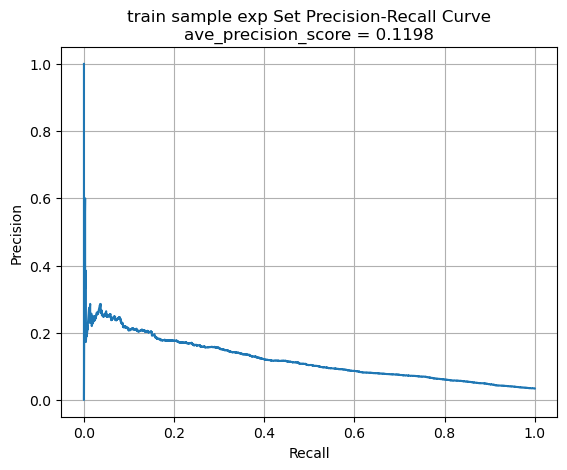

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample exp,0.9655,0.6,0.002595,0.9652,0.05,0.0009,0.0017,0.5013


In [23]:
eval_train_exp_results = bin_class_utils.eval_class(train_cap_x_df, train_y_df, composite_estimator_exp, "train sample exp", CVS_SCORING_LIST)
eval_train_exp_results

Evaluate the trained estimator performance on validation sample exp set
Check accuracy score
validation sample exp set accuracy score: 0.9653979238754326

Check classification report
{'0': {'precision': 0.9656242539985677, 'recall': 0.9997528423133959, 'f1-score': 0.9823922282938676, 'support': 8092.0}, '1': {'precision': 0.3333333333333333, 'recall': 0.0034602076124567475, 'f1-score': 0.006849315068493151, 'support': 289.0}, 'accuracy': 0.9653979238754326, 'macro avg': {'precision': 0.6494787936659505, 'recall': 0.5016065249629263, 'f1-score': 0.4946207716811804, 'support': 8381.0}, 'weighted avg': {'precision': 0.9438211188032147, 'recall': 0.9653979238754326, 'f1-score': 0.9487528174929927, 'support': 8381.0}}

Check confusion matrix
validation sample exp set confusion matrix: 
[[8090    2]
 [ 288    1]]
True Positives =  8090
True Negatives =  1
False Positives(Type I error) =  2
False Negatives(Type II error) =  288

Check cross validation score

accuracy scores: [0.96302922 0.964

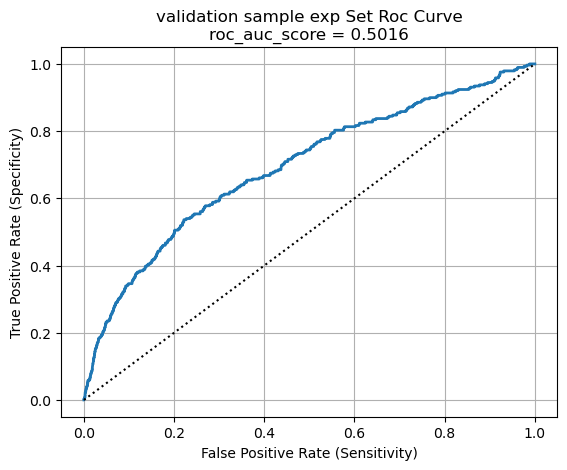


Check Precision-Recall Curve and Average Precision Score


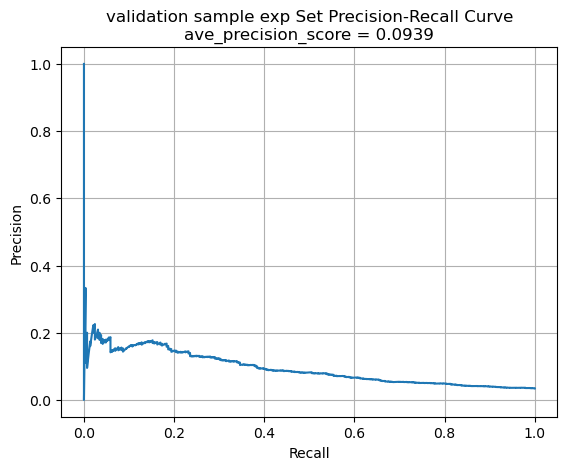

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,validation sample exp,0.9654,0.333333,0.00346,0.9644,0.25,0.007,0.0133,0.5016


In [24]:
eval_validation_exp_results = bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, composite_estimator_exp, "validation sample exp", CVS_SCORING_LIST)
eval_validation_exp_results

#### 13. Decide attrs to drop for fine-tuning

In [25]:
compare_df = pd.concat([eval_train_results, eval_validation_results, eval_train_exp_results, eval_validation_exp_results], axis=0)
compare_df

,stage,accuracy,precision,recall,cv_mean_accuracy,cv_mean_precision,cv_mean_recall,cv_mean_f1,roc_auc_score
0,train sample,0.9655,0.428571,0.002595,0.9654,0.00,0.0000,0.0000,0.5012
0,validation sample,0.9649,0.000000,0.000000,0.9650,0.10,0.0034,0.0067,0.4997
0,train sample exp,0.9655,0.600000,0.002595,0.9652,0.05,0.0009,0.0017,0.5013
0,validation sample exp,0.9654,0.333333,0.003460,0.9644,0.25,0.0070,0.0133,0.5016


- The model performances before and after dropping some common least important features in permutation importance test are similar. 
- `accuracy scores` are very close and high. 
- `recall score` for class 1 doesn't change but `precision score` show some improvements.
- `false positives (Type I error)` are very close and low.
- `roc_auc_score` and the mean of `precision scores` in cross validation don't show much differences. 
- Because dropping attributes doesn't significantly decrease the performance, we would apply the new drop list in the fine-tuning stage.

In [26]:
attrs_to_drop_for_fine_tuning = attrs_to_drop_exp

attrs_to_drop_for_fine_tuning

['device_size',
 'pt_d',
 'spread_app_id',
 'career',
 'emui_dev',
 'app_score',
 'communication_avgonline_30d',
 'adv_prim_id',
 'gender',
 'list_time',
 'uid',
 'task_id',
 'tags',
 'dev_id',
 'city_rank',
 'his_on_shelf_time',
 'communication_onlinerate',
 'device_price']

In [27]:
end = time.time()
print(f'Script run time: {(end - start)/60} minutes')

Script run time: 2.3261616150538127 minutes
